In [1]:
import cv2
import numpy as np
import imutils
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

# 9. Проект

# 9.1 Обзор функций, которые используются в проекте

# Обзор функции get_color()
Рассмотрим функцию get_color(), которая принимает изображение в формате HSV. В ней инициализируется объект KMeans. Затем метод fit вызывается на объекте KMeans и передается массив pixels для обучения алгоритма кластеризации. После обучения KMeans, функция получает координаты центра кластера с наибольшим количеством пикселей, используя kmeans.cluster_centers[0] Полученный главный цвет представлен в виде массива координат RGB и преобразуется в список с помощью list(). Наконец, функция возвращает доминирующий цвет.

In [2]:
def get_color(image):
    pixels = np.float32(image.reshape(-1, 3))
    n_colors = 1
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    dominant_color = list(kmeans.cluster_centers_[0])

    return dominant_color

# Обзор функции shelf()

Функция def shelf () предназначена для удаления фона. В процессе работы этой программы сканируется все строки, начиная с верхней. Если при сканировании интенсивности пикселей не меняются, то они обнуляются. В результате на изображении фон становится темным.

In [3]:
def shelf (img, k = 120):
    x = 0
    
    for i in range (img.shape[1]):
        if x > ((img.shape[1])/1.01):
            img[i-1] = [0, 0, 0]
            img[i-2] = [0, 0, 0]
            x = 0
        for j in range(img.shape[0]):
            if(img[i][0][0] - k <= img[i][j][0] <=
            img[i][0][0] + k) and (
                img[i][0][1] - k <= img[i][j][1] <=
                img[i][0][1] + k
            ) and (
                img[i][0][2] - k <= img[i][j][2] <=
                img[i][0][2] + k
            ):
                x += 1
    
    return img.astype(np.uint8)

Продемонстрируем работу функции shelf():

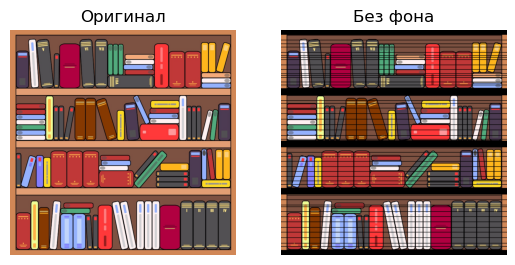

In [4]:
img = cv2.imread("images/shelf.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (900, 900))

res = np.copy(img)
res = shelf(res, k=40)

plt.subplot(121), plt.imshow(img), plt.title('Оригинал')
plt.axis('off')
plt.subplot(122), plt.imshow(res), plt.title('Без фона')
plt.axis('off')
plt.show()

Так как эта функция сканирует строки, и обнуляет те, в которых значение интенсивности пикселей не меняются, её работа неточна и подойдёт для малого количества изображений.

# Обзор функции background() 

In [5]:
def background(imr, p = 40):
    hsv_image = cv2.cvtColor(imr, cv2.COLOR_BGR2HSV)
    dom_color = get_color(hsv_image)
    dom_color_hsv = np.full(imr.shape, [255,255,255], dtype='uint8')
    lower = np.array([dom_color[0]-p, dom_color[1]-p, dom_color[2]-p])
    upper = np.array([dom_color[0]+p, dom_color[1]+p, dom_color[2]+p])
    
    mask = cv2.inRange(hsv_image, lower, upper)
    res = cv2.bitwise_not(dom_color_hsv, hsv_image, mask=mask)
    
    return cv2.cvtColor(res, cv2.COLOR_HSV2BGR)

Аргумент p представляет собой параметр для определния диапазона цветов. background() использует определённую раннее функию get_color и сохраняет полученное знчение в переменной dom_color. Затем функция создает верхние и нижние диапазоны цветовых значений. Значения верхнего диапазона увеличиваются на p, а нижнего уменьшаются. Затем создаётся маска по верхним и нижним диапазонам. Затем маска применяется к изображению, в результате получаем изображение без фона. 

Продемонстрируем работу функции:

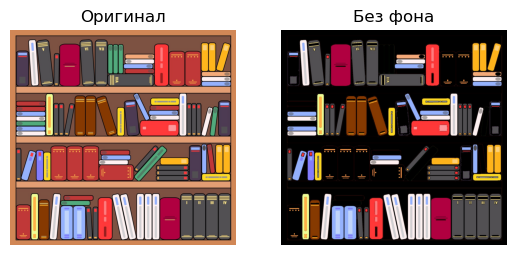

In [6]:
img = cv2.imread('images/shelf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imr = background(img, p=75)

plt.subplot(121), plt.imshow(img), plt.title('Оригинал')
plt.axis('off')
plt.subplot(122), plt.imshow(imr), plt.title('Без фона')
plt.axis('off')
plt.show()

# Обзор функции segment()
Функция segment() предназначена для разбиения всего поля изображения на сегменты, с последующей их маркировкой. Используя функцию cv2.threshold, получим, задавая порог 100, бинарное изображение. Затем создадим ядро и воспользуемся морфологической функцией cv2.morphologyEx() в режиме открытия. Операция открытия – это последовательность двух операций: сначала
применяется операция эрозии, потом операция расширения. Операция открытия хорошо удаляет шум с изображения. Затем полученное изображение обрабатывается операцией закрытия. 

In [7]:
def segment (img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    im_bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((3,3) , np.uint8)
    opening = cv2.morphologyEx(
        im_bw, cv2.MORPH_OPEN, kernel, iterations = 1
    )
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.01*dist_transform.max(), 255, 0
    )
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.Canny(sure_bg, 200, 200, apertureSize=3)
    ret, mark = cv2.connectedComponents(sure_fg)
    mark += 1
    mark[unknown == 255] = 0
    markers = cv2.watershed(img, mark)
    img[markers == -1] = [255, 0, 0]
    
    return img, im_bw, unknown

После бинаризации изображения и очистки его от шума увеличиевается расстояние между объектами. Для этого применяется distanceTransform, а затем к полученному изображению применяется пороговая обработка. Выделим контуры методом Кенни, а затем присовим каждой области внутри контура некоторый символ. Это и называется операцией маркировки. Сегментация изображения проводится методом водораздела cv2.watershed()

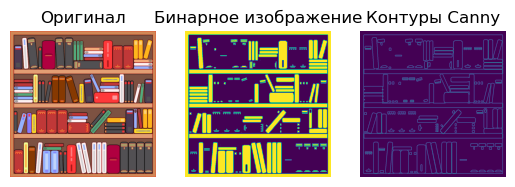

In [8]:
img = cv2.imread('images/shelf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (900, 900))

img, im_bw, canny = segment(img)

plt.subplot(131), plt.imshow(img), plt.title('Оригинал')
plt.axis('off')
plt.subplot(132), plt.imshow(im_bw), plt.title('Бинарное изображение')
plt.axis('off')
plt.subplot(133), plt.imshow(canny), plt.title('Контуры Canny')
plt.axis('off')
plt.show()

# 9.2 Распознование объекта по шаблону
Метод заключается в поиске объекта на большом изображении, который соответсвует выбранному шаблону. Поиск проводится с помощью функции cv2.matchTemplate(). Шаблон перемещается по изображению и его пиксели сравниваются с градациями серого.

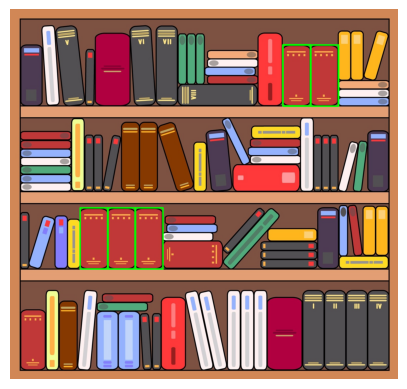

In [9]:
img_rgb = cv2.imread('images/shelf.jpg')
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
template = cv2.imread('images/1.jpg', 0)
w, h = template.shape[::-1]
res = cv2.matchTemplate(
    img_gray, 
    template, 
    cv2.TM_CCOEFF_NORMED
)
threshold = 0.8
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(
        img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2
    )
    
cv2.imwrite('res.png', img_rgb)

plt.axis('off')
plt.imshow(img_rgb);  

Для правильного создания признаков объектов их нужно привести к одинаковому размеру по высоте. Для этого у каждого объекта определяем коэффициент пересчета k = h1/h0, где h0 – стандартная высота, в нашем случае h0 = 160, h1 – старая высота. Тогда новая ширина равна w = w1* h1/h0.

In [10]:
image = cv2.imread('images/1.jpg', 1)
s = image.shape 
h1, w1 = s[0], s[1] 
wr = round(77 * h1 / 160)
img = cv2.resize(image, (wr, 160))
cv2.imwrite("r1.jpg", img)
print(s)
print(w1)

(243, 111, 3)
111


Для создания таблицы признаков объекта цветное изображение
трансформируется в серое. Затем на основе массива точек изображения и массива координат кон-
тура вычисляются все признаки объекта.

0 0 111 14
284.0
253.65490651130676
111 14
7.928571428571429 0.18275418275418276
19.015783725757565
{'m00': 284.0, 'm10': 16501.166666666664, 'm01': 822.3333333333333, 'm20': 1487716.3333333333, 'm11': 51022.25, 'm02': 4676.333333333333, 'm30': 144958391.55, 'm21': 5163155.916666667, 'm12': 305090.2166666667, 'm03': 34437.700000000004, 'mu20': 528954.0045970267, 'mu11': 3242.463419405336, 'mu02': 2295.234350547731, 'mu30': -2949254.741437167, 'mu21': 478622.1489455437, 'mu12': 14605.26164552517, 'mu03': 7605.304907352314, 'nu20': 6.558148241879423, 'nu11': 0.040201143366957647, 'nu02': 0.02845708131506312, 'nu30': -2.1697836692117667, 'nu21': 0.35212506668685395, 'nu12': 0.010745174961584662, 'nu03': 0.005595266544967163}


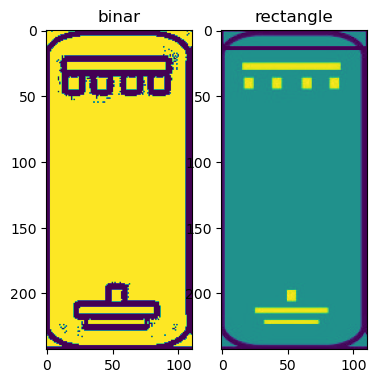

In [11]:
img = cv2. imread('images/1.jpg', 0)
th = cv2.adaptiveThreshold(
    img, 255, 
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    11,2
)
contours, hierarchy = cv2.findContours(th, 5, 5)
plt.subplot(131), plt.imshow(th), plt.title('binar')

cnt = contours[0]
area = cv2.contourArea(cnt)
prm = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)
x, y, w, h = cv2.boundingRect(cnt)
print(x, y, w, h)
imag = cv2.rectangle(
    img, 
    (x, y),
    (x+w,y+h),
    (0,255,0), 
    2
)
plt.subplot(132), plt.imshow(imag), plt.title('rectangle')
x, y, w, h = cv2.boundingRect(cnt)
epsilon = 0.1 * cv2.arcLength(cnt, True)
aspect_ratio = float(w) / h
rect_area = w * h
extent = float(area) / rect_area
hull_area = cv2.contourArea(hull)
equi_diameter = np.sqrt(4 * area / np.pi)
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1)
M = cv2.moments(cnt)
x, y, w, h = cv2.boundingRect(cnt)
pixelpoints = np.transpose(np.nonzero(mask))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img, mask=mask)
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])
print(area)
print(prm)
print(w,h)
print(aspect_ratio, extent)
print(equi_diameter)
print(M)